In [27]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


In [28]:
# Load the JSONL dataset
records = []
with open('2025-05-07-06-14-12_oss_eval.jsonl', 'r') as f:
    for line in f:
        records.append(json.loads(line))
df = pd.json_normalize(records)
print(f"Loaded {len(df)} examples.")

# Display dataset structure
print("\nDataset columns:")
print(df.columns.tolist())

# Basic info about the dataset
print("\nSample record structure:")
sample_record = records[0]
for key, value in sample_record.items():
    if isinstance(value, list) and len(value) > 0:
        print(f"{key}: List with {len(value)} items")
    else:
        print(f"{key}: {type(value).__name__}")


Loaded 5000 examples.

Dataset columns:
['example_tags', 'ideal_completions_data', 'prompt', 'prompt_id', 'rubrics', 'canary', 'ideal_completions_data.ideal_completion', 'ideal_completions_data.ideal_completions_group', 'ideal_completions_data.ideal_completions_ref_completions']

Sample record structure:
example_tags: List with 2 items
ideal_completions_data: NoneType
prompt: List with 1 items
prompt_id: str
rubrics: List with 19 items
canary: str


Rubric count statistics:
Mean: 11.45
Median: 11.00
Min: 2
Max: 48


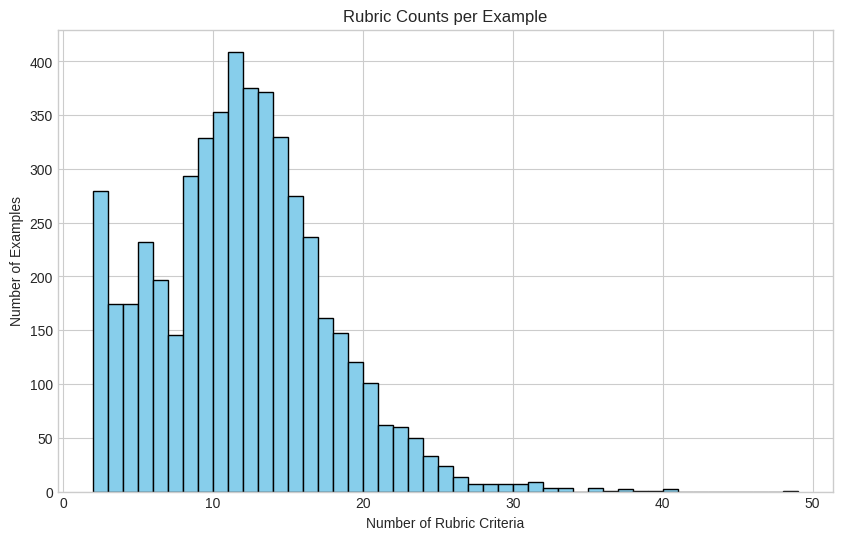

In [29]:
# Calculate number of rubrics per example
df['num_rubrics'] = df['rubrics'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Plot distribution
plt.hist(df['num_rubrics'], bins=range(df['num_rubrics'].min(), df['num_rubrics'].max()+2), 
         edgecolor='black', color='skyblue')
plt.xlabel('Number of Rubric Criteria')
plt.ylabel('Number of Examples')
plt.title('Rubric Counts per Example')

# Add summary statistics
print(f"Rubric count statistics:")
print(f"Mean: {df['num_rubrics'].mean():.2f}")
print(f"Median: {df['num_rubrics'].median():.2f}")
print(f"Min: {df['num_rubrics'].min()}")
print(f"Max: {df['num_rubrics'].max()}")
plt.show()


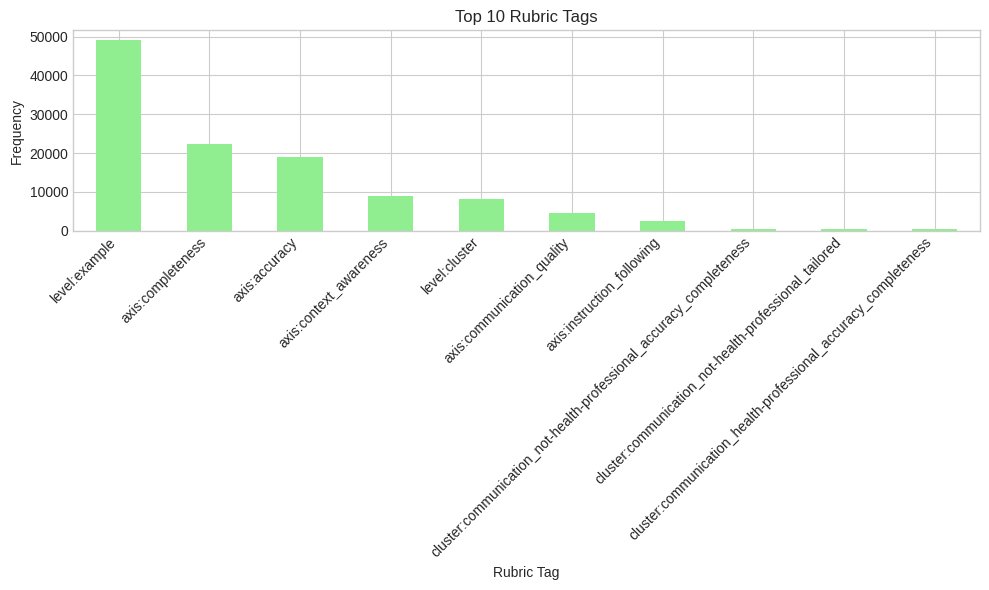

Total unique tags: 44

Top 10 tags:


rubrics
level:example                                                          49184
axis:completeness                                                      22285
axis:accuracy                                                          18888
axis:context_awareness                                                  8991
level:cluster                                                           8053
axis:communication_quality                                              4522
axis:instruction_following                                              2551
cluster:communication_not-health-professional_accuracy_completeness      424
cluster:communication_not-health-professional_tailored                   424
cluster:communication_health-professional_accuracy_completeness          322
Name: count, dtype: int64

In [30]:
# Extract all tags from all rubrics
all_tags = df['rubrics'].explode().dropna().apply(lambda r: r.get('tags', [])).explode()
tag_counts = all_tags.value_counts().head(10)

# Plot top 10 tags
tag_counts.plot.bar(color='lightgreen')
plt.xlabel('Rubric Tag')
plt.ylabel('Frequency')
plt.title('Top 10 Rubric Tags')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display tag statistics
print(f"Total unique tags: {all_tags.nunique()}")
print(f"\nTop 10 tags:")
display(tag_counts)


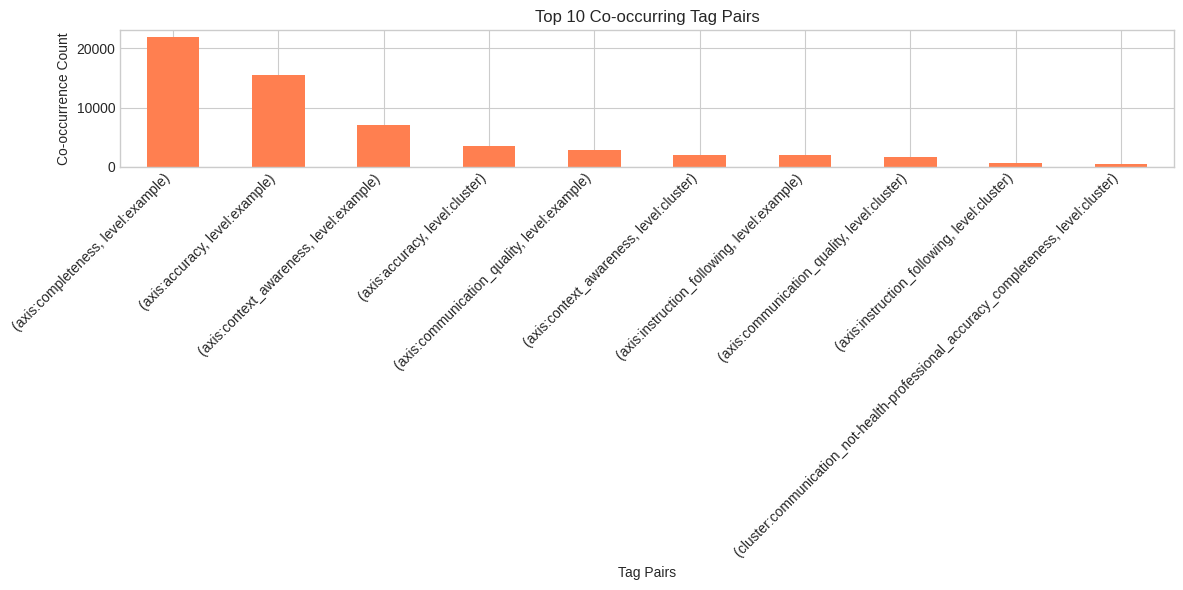


Top 10 co-occurring tag pairs:


(axis:completeness, level:example)                                                      21966
(axis:accuracy, level:example)                                                          15419
(axis:context_awareness, level:example)                                                  7005
(axis:accuracy, level:cluster)                                                           3469
(axis:communication_quality, level:example)                                              2818
(axis:context_awareness, level:cluster)                                                  1986
(axis:instruction_following, level:example)                                              1976
(axis:communication_quality, level:cluster)                                              1704
(axis:instruction_following, level:cluster)                                               575
(cluster:communication_not-health-professional_accuracy_completeness, level:cluster)      424
Name: count, dtype: int64

In [31]:
def get_tag_pairs(tags):
    """Extract all unique pairs of tags from a list of tags"""
    pairs = []
    if isinstance(tags, list) and len(tags) > 1:
        for i in range(len(tags)):
            for j in range(i+1, len(tags)):
                pairs.append(tuple(sorted([tags[i], tags[j]])))
    return pairs

# Extract all tag pairs from rubrics
all_tag_pairs = []
for rubrics in df['rubrics']:
    if isinstance(rubrics, list):
        for rubric in rubrics:
            all_tag_pairs.extend(get_tag_pairs(rubric.get('tags', [])))

# Count and display top co-occurring pairs
pair_counts = pd.Series(all_tag_pairs).value_counts().head(10)
plt.figure(figsize=(12, 6))
pair_counts.plot(kind='bar', color='coral')
plt.title('Top 10 Co-occurring Tag Pairs')
plt.xlabel('Tag Pairs')
plt.ylabel('Co-occurrence Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print('\nTop 10 co-occurring tag pairs:')
display(pair_counts)


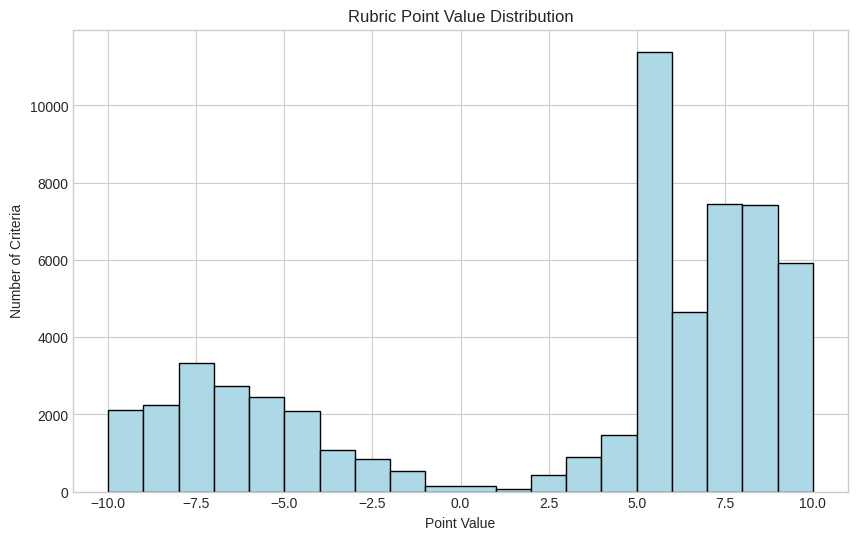

Point value statistics:
Mean: 2.46
Median: 5.00
Min: -10
Max: 10

Point value frequency:


points
-10     2113
-9      2237
-8      3332
-7      2741
-6      2454
-5      2089
-4      1085
-3       855
-2       531
-1       138
 1        71
 2       439
 3       902
 4      1459
 5     11392
 6      4649
 7      7434
 8      7409
 9      3827
 10     2080
Name: count, dtype: int64

In [32]:
# Create a flattened dataframe of all rubrics
all_rubrics = pd.json_normalize(df['rubrics'].explode().dropna())

# Plot distribution of point values
plt.hist(all_rubrics['points'], bins=sorted(set(all_rubrics['points'])), 
         edgecolor='black', color='lightblue')
plt.xlabel('Point Value')
plt.ylabel('Number of Criteria')
plt.title('Rubric Point Value Distribution')
plt.show()

# Display point value statistics
print(f"Point value statistics:")
print(f"Mean: {all_rubrics['points'].mean():.2f}")
print(f"Median: {all_rubrics['points'].median():.2f}")
print(f"Min: {all_rubrics['points'].min()}")
print(f"Max: {all_rubrics['points'].max()}")
print(f"\nPoint value frequency:")
display(all_rubrics['points'].value_counts().sort_index())


Rubric Axis Summary:


,axis,num_criteria,avg_points,min_points,max_points
0,accuracy,18888,1.94,-10,10
1,communication_quality,4522,1.31,-10,10
2,completeness,22285,2.93,-10,10
3,context_awareness,8991,3.14,-10,10
4,instruction_following,2551,1.74,-10,10


<Figure size 1200x600 with 0 Axes>

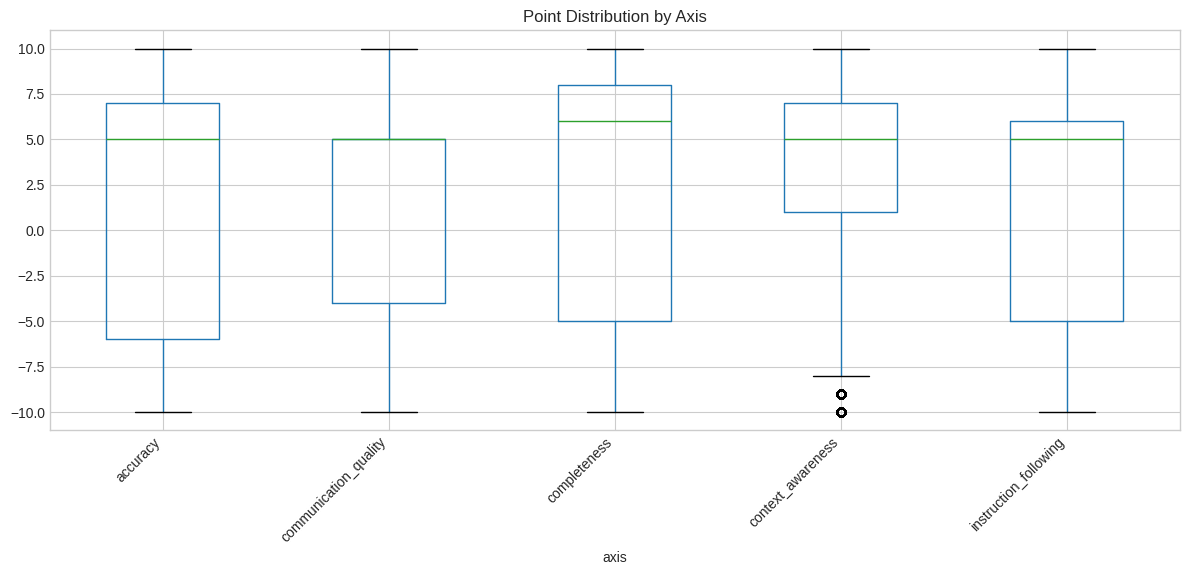

In [33]:
# Extract axis from tags
def extract_axis(tags):
    """Extract the axis value from a list of tags"""
    for tag in tags:
        if tag.startswith('axis:'):
            return tag.split(':', 1)[1]
    return None

# Add axis to the rubrics dataframe
all_rubrics['axis'] = all_rubrics['tags'].apply(extract_axis)

# Summarize by axis
axis_summary = all_rubrics.dropna(subset=['axis']).groupby('axis')['points'].agg(
    num_criteria='count', 
    avg_points='mean',
    min_points='min',
    max_points='max'
).round(2).reset_index()

print('Rubric Axis Summary:')
display(axis_summary)

# Visualize point distribution by axis
plt.figure(figsize=(12, 6))
all_rubrics.boxplot(column='points', by='axis', figsize=(12, 6))
plt.title('Point Distribution by Axis')
plt.suptitle('')  # Remove automatic suptitle
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


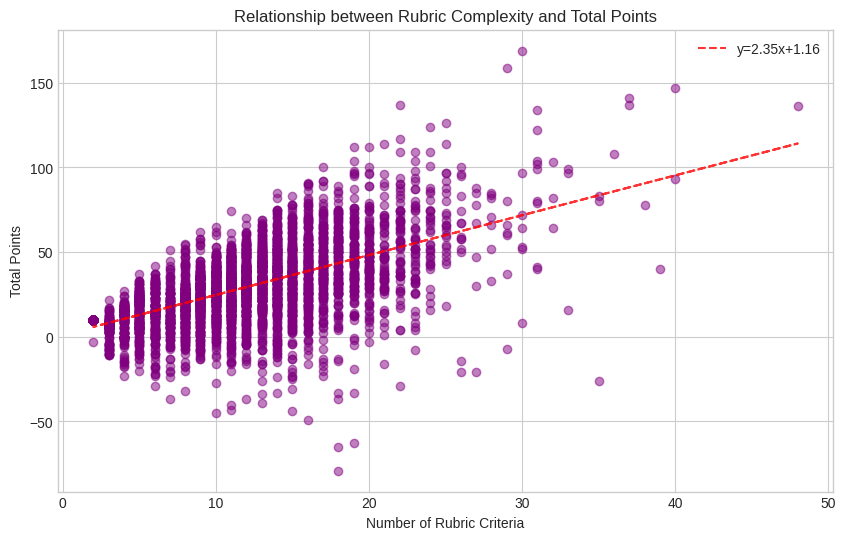

Correlation between number of rubrics and total points: 0.608
Average points per rubric: 2.55


In [34]:
# Calculate complexity metrics
df['total_points'] = df['rubrics'].apply(lambda x: sum(r['points'] for r in x) if isinstance(x, list) else 0)
df['avg_points_per_rubric'] = df['total_points'] / df['num_rubrics'].replace(0, float('nan'))

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['num_rubrics'], df['total_points'], alpha=0.5, color='purple')
plt.xlabel('Number of Rubric Criteria')
plt.ylabel('Total Points')
plt.title('Relationship between Rubric Complexity and Total Points')

# Add trend line
z = np.polyfit(df['num_rubrics'], df['total_points'], 1)
p = np.poly1d(z)
plt.plot(df['num_rubrics'], p(df['num_rubrics']), 'r--', alpha=0.8, 
         label=f'y={z[0]:.2f}x+{z[1]:.2f}')
plt.legend()
plt.show()

# Display correlation and summary statistics
correlation = df['num_rubrics'].corr(df['total_points'])
print(f"Correlation between number of rubrics and total points: {correlation:.3f}")
print(f"Average points per rubric: {df['avg_points_per_rubric'].mean():.2f}")


Medical Category Distribution:


medical_category
not-health-professional             424
health-professional                 322
any-reducible-uncertainty           285
no-uncertainty                      228
enough-context                      227
context-does-not-matter             220
context-matters-but-unclear         219
enough-info-to-complete-task        215
only-irreducible-uncertainty        198
context-matters-is-clear            195
not-enough-context                  181
not-enough-info-to-complete-task    180
conditionally-emergent              180
simple                              163
detailed                            161
emergent                            139
non-emergent                        134
Name: count, dtype: int64

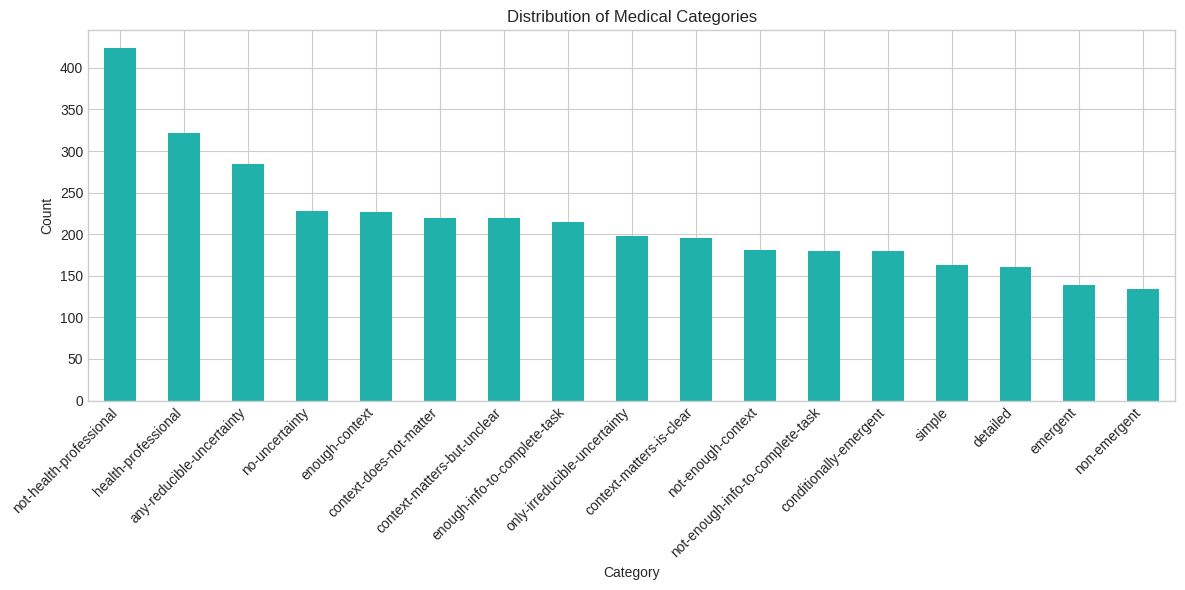


Theme Distribution:


theme
global_health          1097
hedging                1071
communication           919
context_seeking         594
emergency_referrals     482
health_data_tasks       477
complex_responses       360
Name: count, dtype: int64

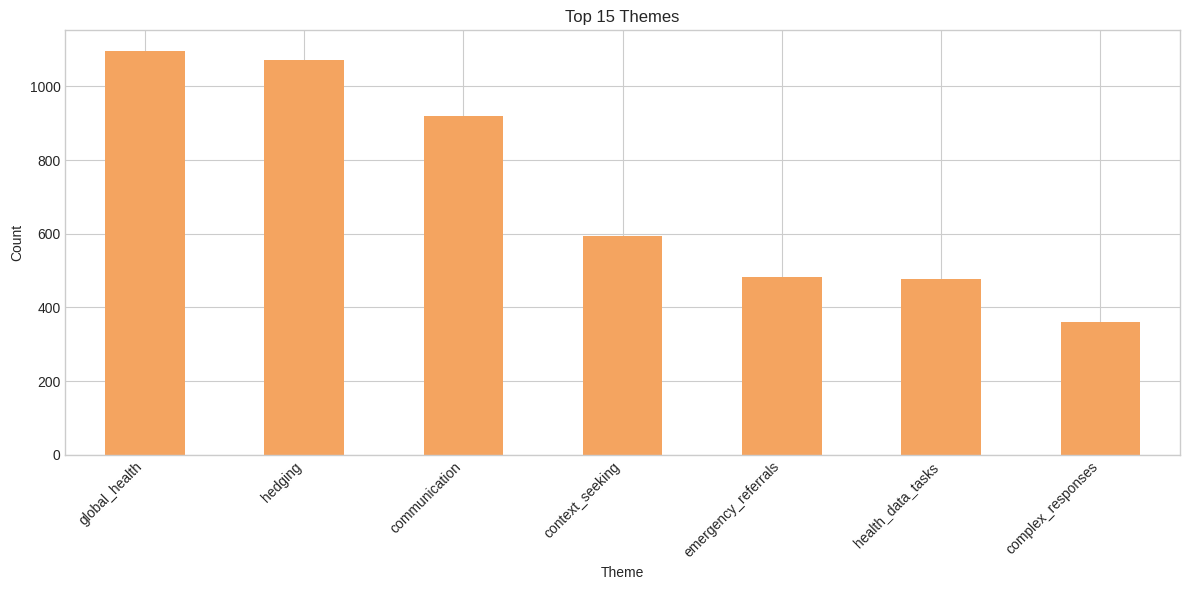

In [35]:
# Extract medical categories and themes
df['medical_category'] = df['example_tags'].apply(
    lambda x: next((tag.replace('physician_agreed_category:', '') 
                    for tag in x if 'physician_agreed_category:' in tag), None))
df['theme'] = df['example_tags'].apply(
    lambda x: next((tag.replace('theme:', '') for tag in x if 'theme:' in tag), None))

# Medical Category Analysis
print('Medical Category Distribution:')
med_cat_dist = df['medical_category'].value_counts()
display(med_cat_dist)

plt.figure(figsize=(12, 6))
med_cat_dist.plot(kind='bar', color='lightseagreen')
plt.title('Distribution of Medical Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Theme Analysis
print('\nTheme Distribution:')
theme_dist = df['theme'].value_counts().head(15)
display(theme_dist)

plt.figure(figsize=(12, 6))
theme_dist.plot(kind='bar', color='sandybrown')
plt.title('Top 15 Themes')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Single-turn conversations: 2915 (58.30%)
Multi-turn conversations: 2085 (41.70%)


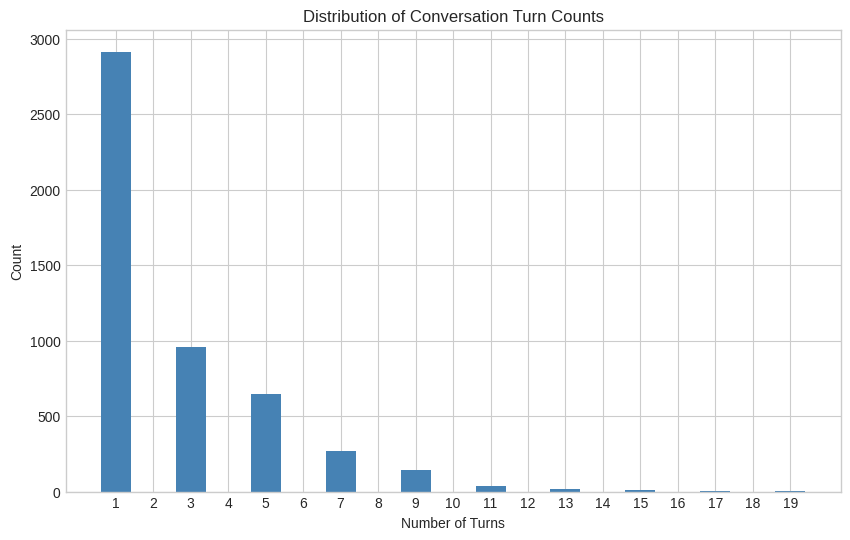

In [36]:
# Calculate conversation metrics
df['turns'] = df['prompt'].apply(len)
df['first_user_message'] = df['prompt'].apply(lambda p: next((turn['content'] for turn in p if turn['role'] == 'user'), ''))
df['message_len'] = df['first_user_message'].apply(len)

# Single vs multi-turn analysis
single_turn = df[df['turns'] == 1].shape[0]
multi_turn = df[df['turns'] > 1].shape[0]
print(f"Single-turn conversations: {single_turn} ({single_turn/len(df)*100:.2f}%)")
print(f"Multi-turn conversations: {multi_turn} ({multi_turn/len(df)*100:.2f}%)")

# Turn distribution plot
plt.figure(figsize=(10, 6))
turn_counts = df['turns'].value_counts().sort_index()
plt.bar(turn_counts.index, turn_counts.values, color='steelblue')
plt.title('Distribution of Conversation Turn Counts')
plt.xlabel('Number of Turns')
plt.ylabel('Count')
plt.xticks(range(1, df['turns'].max() + 1))
plt.show()


Message length statistics:
Mean: 157.8
Median: 103.0
Min: 4
Max: 2792


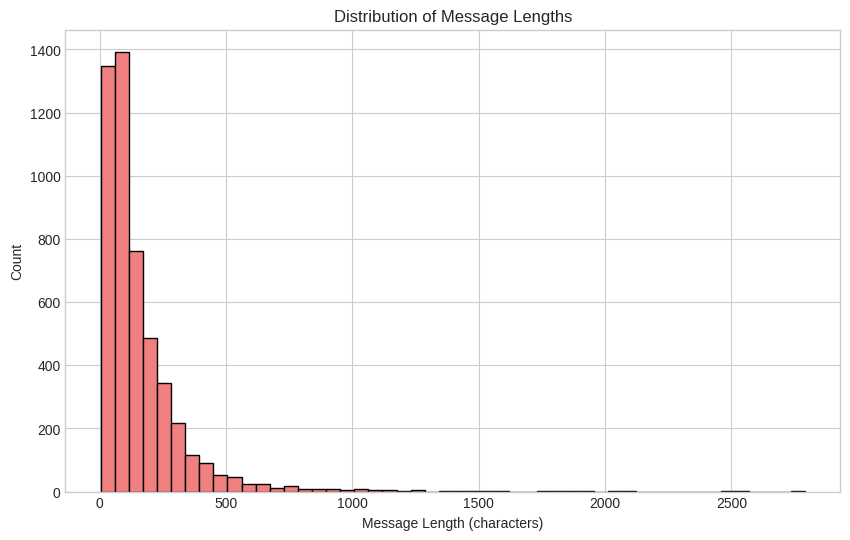

In [37]:
# Message length statistics
msg_len_stats = {
    'mean': df['message_len'].mean(),
    'median': df['message_len'].median(),
    'min': df['message_len'].min(),
    'max': df['message_len'].max()
}
print(f"Message length statistics:")
print(f"Mean: {msg_len_stats['mean']:.1f}")
print(f"Median: {msg_len_stats['median']:.1f}")
print(f"Min: {msg_len_stats['min']}")
print(f"Max: {msg_len_stats['max']}")

# Message length distribution
plt.figure(figsize=(10, 6))
plt.hist(df['message_len'], bins=50, edgecolor='black', color='lightcoral')
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length (characters)')
plt.ylabel('Count')
plt.show()


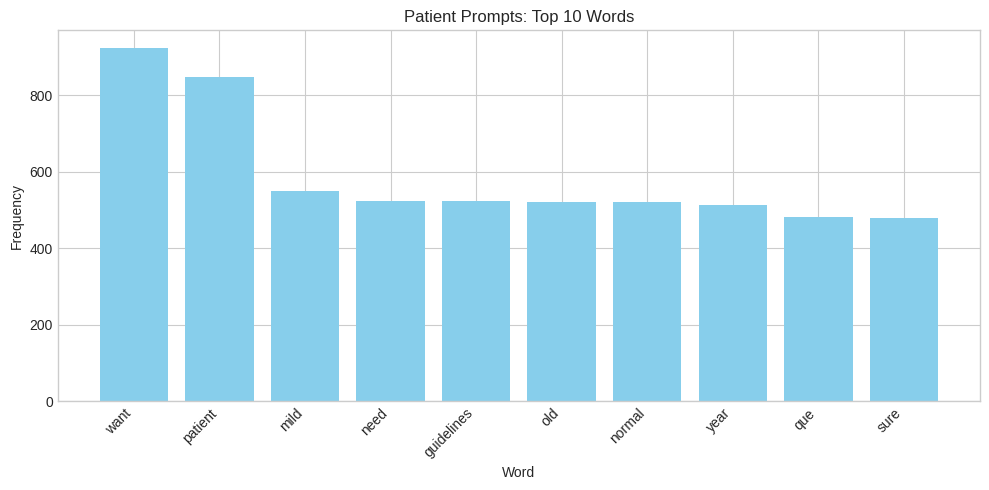

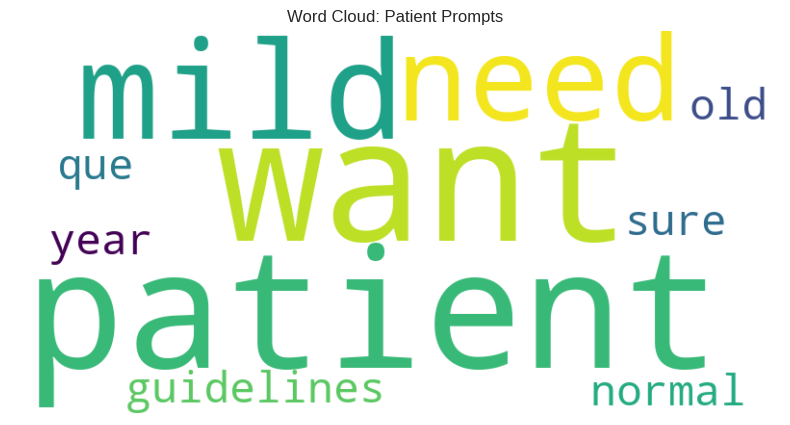

Top 30 Patient Words:
want, patient, mild, need, guidelines, old, normal, year, que, sure, might, recommended, pain, ve, know, something, help, see, postpartum, note, doctor, keep, worried, daily, new, don, therapy, really, medication, right


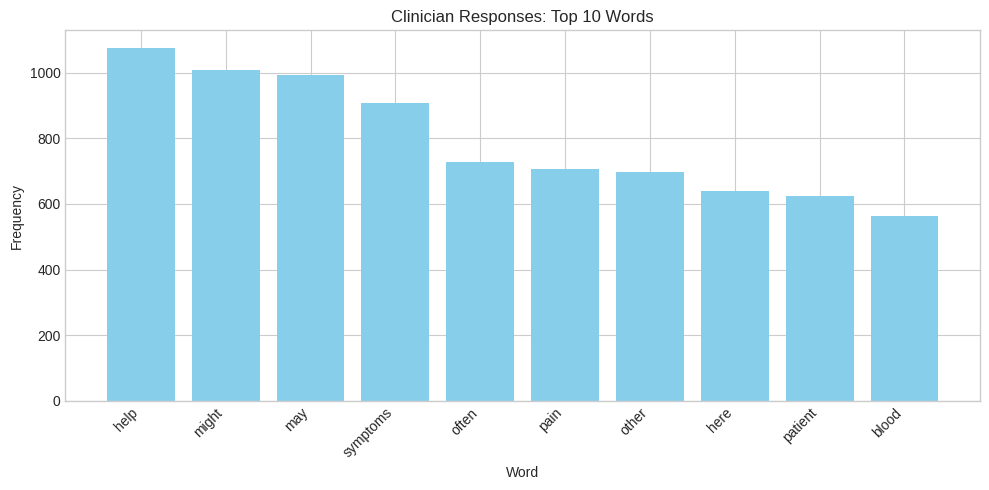

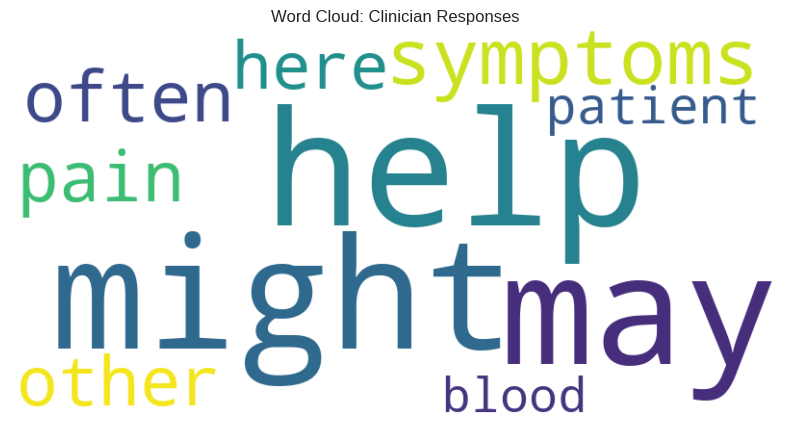


Top 30 Clinician Words:
help, might, may, symptoms, often, pain, other, here, patient, blood, medical, health, these, risk, mild, healthcare, factors, que, possible, professional, changes, guidelines, consider, specific, details, para, typically, severe, know, medication


In [38]:
# Prepare containers for text by role
user_text = []
assistant_text = []

# Extract text by role
for _, row in df.iterrows():
    for msg in row['prompt']:
        if msg['role'] == 'user':
            user_text.append(msg['content'])
        elif msg['role'] == 'assistant':
            assistant_text.append(msg['content'])

# Define tokenization and enhanced stopwords
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

# Enhanced stopwords including single letters, numbers, and multilingual common words
stopwords = set([
    # Standard English stopwords
    'the', 'and', 'to', 'a', 'of', 'i', 'in', 'is', 'it', 'for', 'on', 'my', 'with', 'that', 'you', 'have', 
    'are', 'be', 'as', 'was', 'but', 'at', 'or', 'so', 'if', 'can', 'do', 'me', 'am', 'not', 'this', 'your', 
    'we', 'by', 'from', 'an', 'has', 'had', 'will', 'would', 'should', 'could', 'what', 'when', 'which', 'how', 
    'about', 'just', 'like', 'get', 'got', 'been', 'they', 'he', 'she', 'him', 'her', 'their', 'them', 'our', 
    'us', 'who', 'all', 'any', 'some', 'no', 'yes', 'more', 'also', 'than', 'out', 'up', 'down', 'into', 'over', 
    'under', 'after', 'before', 'because', 'why', 'where', 'there', 'then', 'now', 'only', 'too', 'very',
    # Additional multilingual and common words
    'de', 'la', 'el', 'en', 'un', 'una', 'le', 'les', 'du', 'des', 'et', 'ou', 'ne', 'se', 'ce', 'sa', 're', 'son',
    'sur', 'avec', 'pour', 'par', 'dans', 'sans', 'sous', 'entre', 'depuis', 'pendant', 'avant', 'après',
    # Single letters (common artifacts)
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
])

def get_top_words(texts, stopwords, topn=30):
    words = []
    for text in texts:
        words.extend(tokenize(text))
    # Filter out stopwords, single letters, and numbers
    words = [w for w in words if w not in stopwords and len(w) > 1 and not w.isdigit()]
    word_counts = Counter(words)
    return word_counts.most_common(topn)

# Get top 30 words for each role
user_top30 = get_top_words(user_text, stopwords, 30)
assistant_top30 = get_top_words(assistant_text, stopwords, 30)

# Plot function for top 10 visualization
def plot_bar_and_wordcloud(top_words, title_prefix):
    # Use top 10 for visualization
    top10 = top_words[:10]
    words_, counts_ = zip(*top10)
    plt.figure(figsize=(10,5))
    plt.bar(words_, counts_, color='skyblue')
    plt.title(f'{title_prefix}: Top 10 Words')
    plt.ylabel('Frequency')
    plt.xlabel('Word')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top10))
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud: {title_prefix}')
    plt.show()

# Plot for user (patient)
plot_bar_and_wordcloud(user_top30, "Patient Prompts")

# Display top 30 words as comma-separated list
user_words = [word for word, count in user_top30]
print("Top 30 Patient Words:")
print(", ".join(user_words))

# Plot for assistant (clinician)
plot_bar_and_wordcloud(assistant_top30, "Clinician Responses")

# Display top 30 words as comma-separated list
assistant_words = [word for word, count in assistant_top30]
print("\nTop 30 Clinician Words:")
print(", ".join(assistant_words))


In [39]:
# Create summary dataframe
summary = pd.DataFrame([
    {'Metric': 'Total Examples', 'Value': len(df)},
    {'Metric': 'Average Rubrics per Example', 'Value': f"{df['num_rubrics'].mean():.2f}"},
    {'Metric': 'Average Points per Example', 'Value': f"{df['total_points'].mean():.2f}"},
    {'Metric': 'Average Points per Rubric', 'Value': f"{df['avg_points_per_rubric'].mean():.2f}"},
    {'Metric': 'Single-turn Conversations', 'Value': f"{single_turn} ({single_turn/len(df)*100:.1f}%)"},
    {'Metric': 'Multi-turn Conversations', 'Value': f"{multi_turn} ({multi_turn/len(df)*100:.1f}%)"},
    {'Metric': 'Average Message Length', 'Value': f"{msg_len_stats['mean']:.1f} chars"},
    {'Metric': 'Most Common Medical Category', 'Value': med_cat_dist.index[0] if not med_cat_dist.empty else 'N/A'},
    {'Metric': 'Most Common Theme', 'Value': theme_dist.index[0] if not theme_dist.empty else 'N/A'},
    {'Metric': 'Most Common Rubric Tag', 'Value': tag_counts.index[0] if not tag_counts.empty else 'N/A'},
])

# Display summary
print("HealthBench QnA Dataset Summary:")
display(summary)

print("\n" + "="*80)
print("KEY INSIGHTS FOR HEALTHCARE PROFESSIONALS")
print("="*80)

print("\n1. DATASET SCOPE AND DIVERSITY")
print("   The dataset contains a diverse range of medical conversations with varying complexity,")
print("   providing comprehensive coverage of medical AI interaction scenarios.")

print(f"\n2. EVALUATION COMPLEXITY CORRELATION")
print(f"   Rubric complexity shows a moderate correlation ({correlation:.3f}) with total points,")
print("   indicating that more complex medical scenarios receive more rigorous evaluation.")

print(f"\n3. CONVERSATION PATTERNS")
print(f"   {single_turn/len(df)*100:.1f}% of conversations are single-turn, indicating a predominant direct Q&A format.")
print("   This suggests most patients seek straightforward medical information rather than")
print("   extended consultative discussions.")

print("\n4. MEDICAL CATEGORIZATION")
print("   The analysis reveals clear patterns in medical categories and themes that can guide")
print("   evaluation frameworks and help ensure comprehensive coverage across medical specialties.")

print("\n5. COMMUNICATION LANGUAGE PATTERNS")
print("   Word frequency analysis shows distinct vocabulary patterns between patients and clinicians,")
print("   highlighting the importance of appropriate language adaptation in medical AI systems.")

print("\n6. CLINICAL IMPLICATIONS")
print("   - Medical AI systems must be prepared for both simple queries and complex evaluations")
print("   - Evaluation frameworks should scale with conversation complexity")
print("   - Language patterns suggest need for patient-appropriate communication styles")
print("   - Category distribution indicates areas requiring specialized medical AI training")


HealthBench QnA Dataset Summary:


,Metric,Value
0,Total Examples,5000
1,Average Rubrics per Example,11.45
2,Average Points per Example,28.10
3,Average Points per Rubric,2.55
4,Single-turn Conversations,2915 (58.3%)
5,Multi-turn Conversations,2085 (41.7%)
6,Average Message Length,157.8 chars
7,Most Common Medical Category,not-health-professional
8,Most Common Theme,global_health
9,Most Common Rubric Tag,level:example



Key Insights:
1. The dataset contains a diverse range of medical conversations with varying complexity
2. Rubric complexity shows a moderate correlation (0.608) with total points
3. 58.3% of conversations are single-turn, indicating direct Q&A format
4. The analysis reveals patterns in medical categories and themes that can guide evaluation
5. Word frequency analysis shows distinct vocabulary patterns between patients and clinicians
